In [27]:
import sys
print(sys.path)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
# from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


['/Users/otaviomatos/mambaforge/envs/ml/lib/python312.zip', '/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12', '/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/lib-dynload', '', '/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/site-packages']


# Preparação

In [28]:
us_change = pd.read_csv("data/us_change.csv")
us_change
forecast_steps = 20

data = us_change["Consumption"][:-forecast_steps]
covariables = us_change[["Income", "Production", "Savings", "Unemployment"]][:-forecast_steps]

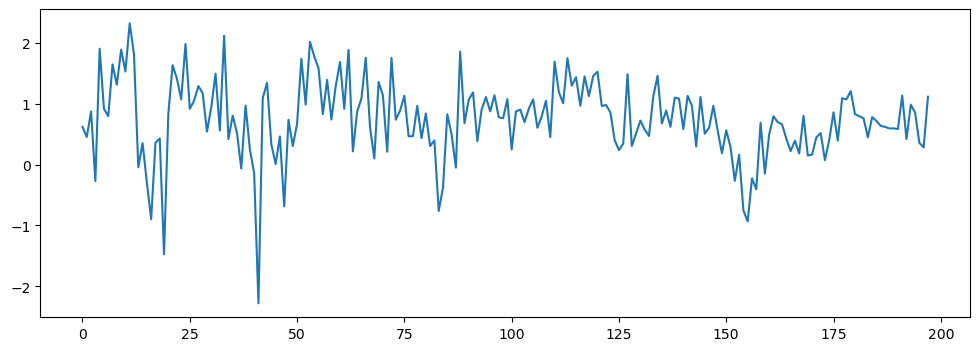

In [29]:
plt.figure(figsize=(12,4))
plt.plot(us_change["Consumption"])

## Testes para stacionariedade 

In [30]:
# KPSS test
kpss_test = kpss(data, regression='c')  # 'c' for constant trend; use 'ct' for linear trend

# Results
print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Number of Lags:", kpss_test[2])
print("Critical Values:", kpss_test[3])

# Interpretation
if kpss_test[1] < 0.05:
    print("Reject the null hypothesis: The series is non-stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Statistic: 0.24964131203487847
p-value: 0.1
Number of Lags: 7
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis: The series is stationary.


/var/folders/06/j3fz87tn3q9fvnw3dfs1ptjr0000gn/T/ipykernel_54793/3692453879.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(data, regression='c')  # 'c' for constant trend; use 'ct' for linear trend


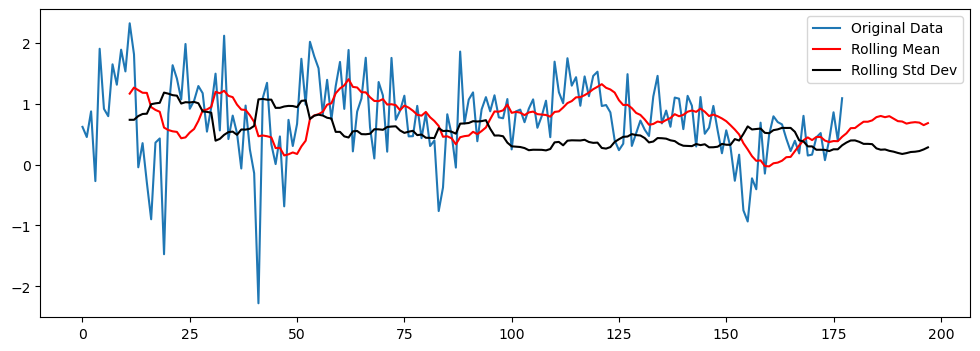

In [31]:
data_rolling_mean = us_change["Consumption"].rolling(window=12).mean()
data_rolling_std = us_change["Consumption"].rolling(window=12).std()

plt.figure(figsize=(12, 4))
plt.plot(data, label='Original Data')
plt.plot(data_rolling_mean, label='Rolling Mean', color='red')
plt.plot(data_rolling_std, label='Rolling Std Dev', color='black')
plt.legend()
plt.show()

Conclusão: A série provavelmente é estacionária.

## ARIMA

Escolhendo os parâmetros visualmente.

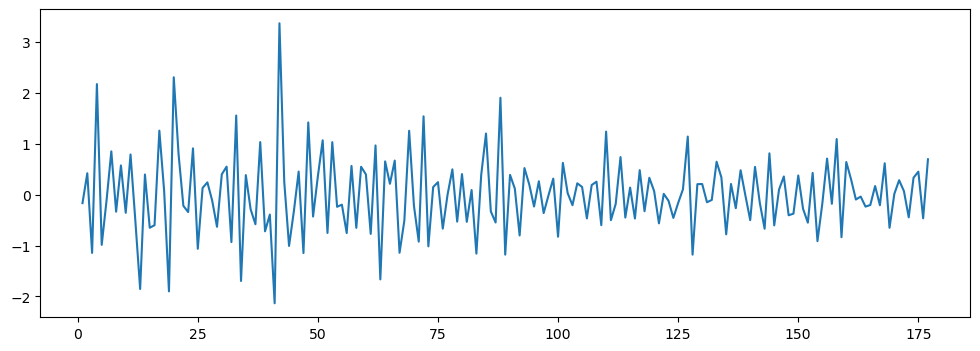

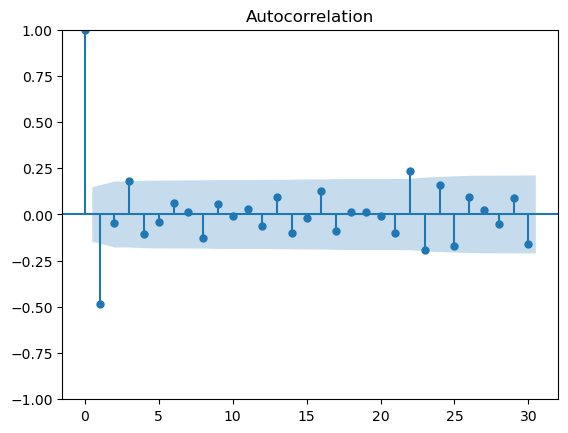

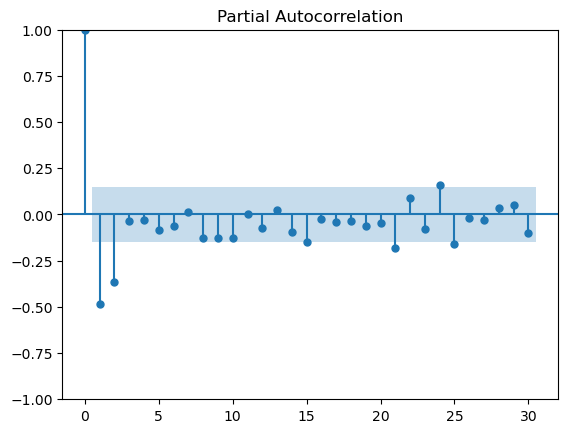

In [32]:
data_diff = data.diff().dropna()

plt.figure(figsize=(12,4))
plt.plot(data_diff)

plot_acf(data_diff, lags=30)
plot_pacf(data_diff, lags=30, method='ywm')
plt.show()

/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  178
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -161.593
Date:                Mon, 25 Nov 2024   AIC                            335.186
Time:                        17:33:07   BIC                            354.243
Sample:                             0   HQIC                           342.914
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0523      0.278      0.188      0.851      -0.493       0.597
ar.L2          0.2103      0.090      2.342      0.019       0.034       0.386
ar.L3          0.2716      0.087      3.106      0.0

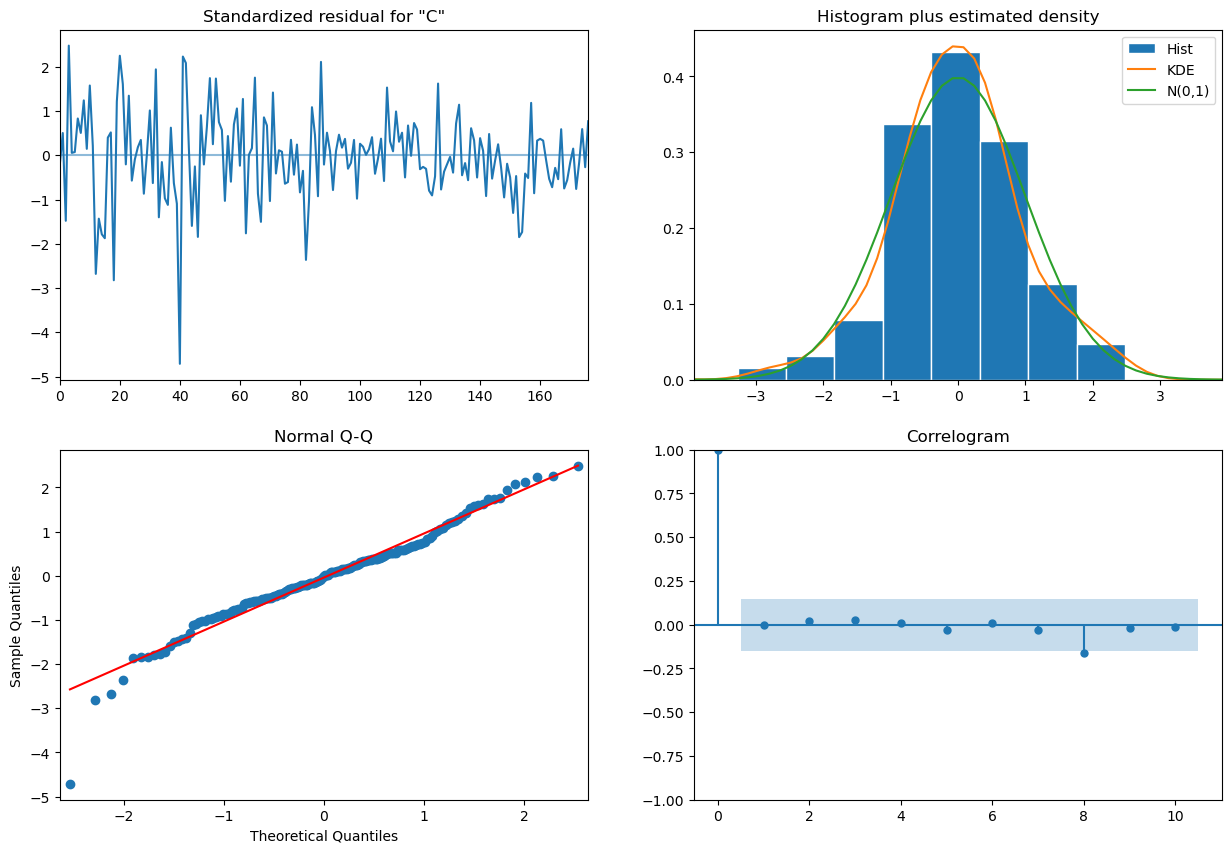

In [33]:
model = ARIMA(data, order=(3,1,2))
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(15, 10))
plt.show()

### Residuals

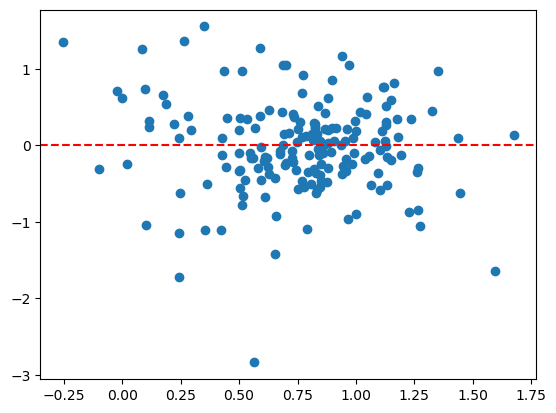

In [34]:
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [35]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(results.resid, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  5.463712   0.858131


## SARIMAX

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15525D-01    |proj g|=  1.23825D+00



 This problem is unconstrained.
/Users/otaviomatos/mambaforge/envs/ml/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


At iterate    5    f=  3.10311D-01    |proj g|=  1.10622D+00

At iterate   10    f=  3.07087D-01    |proj g|=  2.16562D+00

At iterate   15    f=  2.95926D-01    |proj g|=  5.70585D-01

At iterate   20    f=  2.88557D-01    |proj g|=  8.80942D-01

At iterate   25    f=  2.87071D-01    |proj g|=  3.55816D-01

At iterate   30    f=  2.85837D-01    |proj g|=  2.50666D-02

At iterate   35    f=  2.83977D-01    |proj g|=  4.34493D-01

At iterate   40    f=  2.82962D-01    |proj g|=  1.15024D-01

At iterate   45    f=  2.79498D-01    |proj g|=  7.11688D-02

At iterate   50    f=  2.78068D-01    |proj g|=  2.93096D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

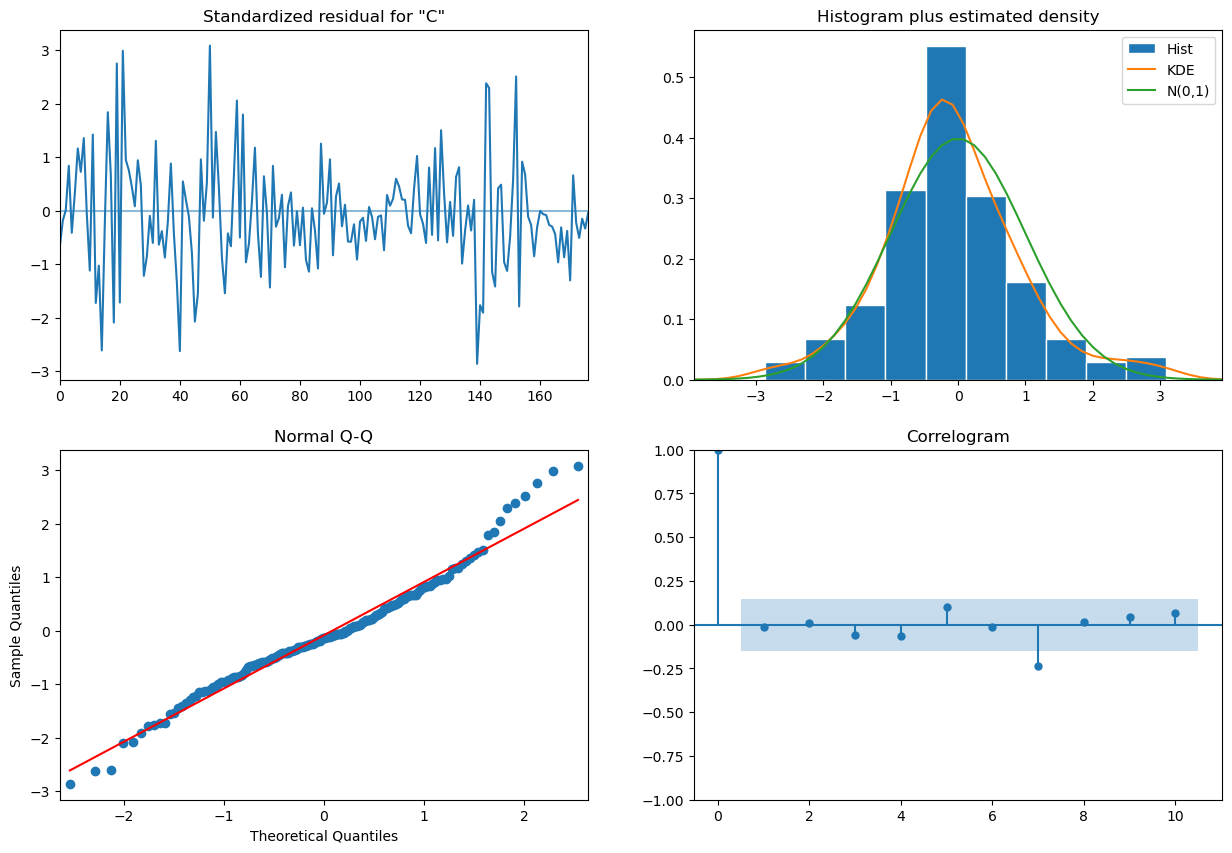

In [36]:
model_x = SARIMAX(data, exog=covariables, order = (3,1,2))
model_x_fit = model_x.fit()

print(model_x_fit.summary())
model_x_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

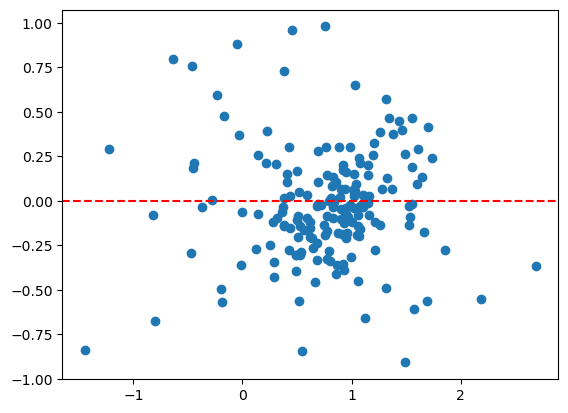

In [37]:
plt.scatter(model_x_fit.fittedvalues, model_x_fit.resid)
plt.axhline(0, color="red", linestyle="--")
plt.show()

In [38]:
# Teste de Ljung-Box
ljung_box_results = acorr_ljungbox(model_x_fit.resid, lags=[10], return_df=True)
print(ljung_box_results)

      lb_stat  lb_pvalue
10  14.199651   0.164078


## Auto Sarimax

In [39]:
# Auto ajuste
auto_model = auto_arima(
    data,
    covariables,
    seasonal=True,
    m=4,  # periodicidade sazonal
    trace=True,  # Mostra o progresso do ajuste
    error_action='ignore',  # Ignora erros
    suppress_warnings=True,  # Suprime avisos
    stepwise=True  # Usa busca passo a passo
)

# Melhores parâmetros
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=126.659, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=249.036, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=172.427, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=119.329, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=247.039, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=116.303, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=121.232, Time=0.20 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=119.135, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=116.348, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=171.955, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=114.558, Time=0.21 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=114.796, Time=0.26 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : AIC=115.955, Time=0.26 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : AIC=inf, Time

# Métricas

In [40]:
# Previsões dentro do período ajustado

fitted_values_arima = results.fittedvalues
fitted_values_sarimax = model_x_fit.fittedvalues
fitted_values_auto_sarimax = auto_model.fittedvalues()

# Previsões fora do período ajustado (exemplo: 20 passos à frente)
forecast_sarima = results.get_forecast(steps=forecast_steps)
forecast_sarimax = model_x_fit.get_forecast(steps=forecast_steps, exog=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:])

forecast_auto_sarimax, conf_interval = auto_model.predict(n_periods=forecast_steps, X=us_change[["Income", "Production", "Savings", "Unemployment"]][-forecast_steps:], return_conf_int = True)

# Valores reais para a previsão
real_values = us_change["Consumption"][-forecast_steps:]

### Sarima

In [41]:
# MAE
mae = mean_absolute_error(data, fitted_values_arima)

# MSE
mse = mean_squared_error(data, fitted_values_arima)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_arima) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_arima)

# AIC
aic = results.aic

# BIC
bic = results.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.44897290424742026
MSE: 0.3654931302893727
RMSE: 0.6045602784581309
MAPE: 184.1516684379851%
R²: 0.17448835469556023
AIC: 335.1856602704999
BIC: 354.24255866594285


In [42]:
mae_outsample = mean_absolute_error(real_values, forecast_sarima.predicted_mean)
mse_outsample = mean_squared_error(real_values, forecast_sarima.predicted_mean)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.21032361000121585, MSE: 0.06751583949841372


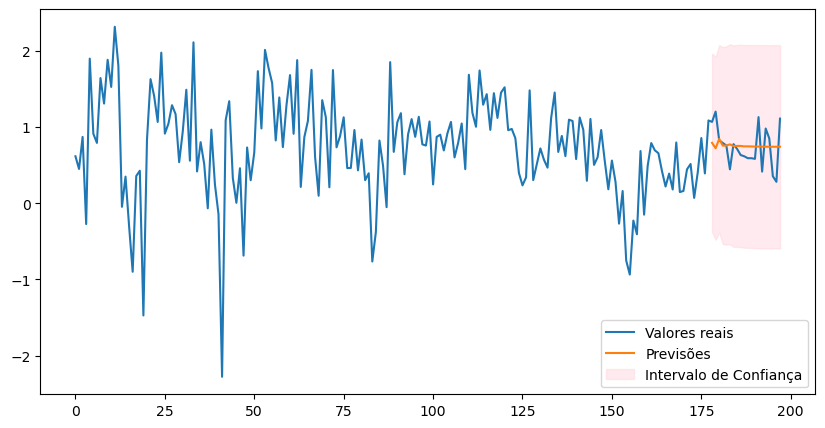

In [43]:
# Intervalo de confiança
conf_int = forecast_sarima.conf_int()

# Visualizar previsões e intervalos
forecast_index = range(len(us_change["Consumption"]) - forecast_steps, len(us_change["Consumption"]))
plt.figure(figsize=(10, 5))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_sarima.predicted_mean, label="Previsões")
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.legend()
plt.show()

### Sarimax

In [44]:
# MAE
mae = mean_absolute_error(data, fitted_values_sarimax)

# MSE
mse = mean_squared_error(data, fitted_values_sarimax)

# RMSE
rmse = np.sqrt(mse)

#MAPE
mape = np.mean(np.abs((data - fitted_values_sarimax) / data)) * 100

# R²
r2 = r2_score(data, fitted_values_sarimax)

# AIC
aic = model_x_fit.aic

# BIC
bic = model_x_fit.bic


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.24025661427609724
MSE: 0.10258705908150718
RMSE: 0.3202921464561802
MAPE: 75.07563332293238%
R²: 0.768294381176824
AIC: 118.99232254017019
BIC: 150.7538198659085


In [45]:
mae_outsample = mean_absolute_error(real_values, forecast_sarimax.predicted_mean)
mse_outsample = mean_squared_error(real_values, forecast_sarimax.predicted_mean)
print(f"Out-of-sample MAE: {mae_outsample}, MSE: {mse_outsample}")

Out-of-sample MAE: 0.0837853234013953, MSE: 0.011225905969320523


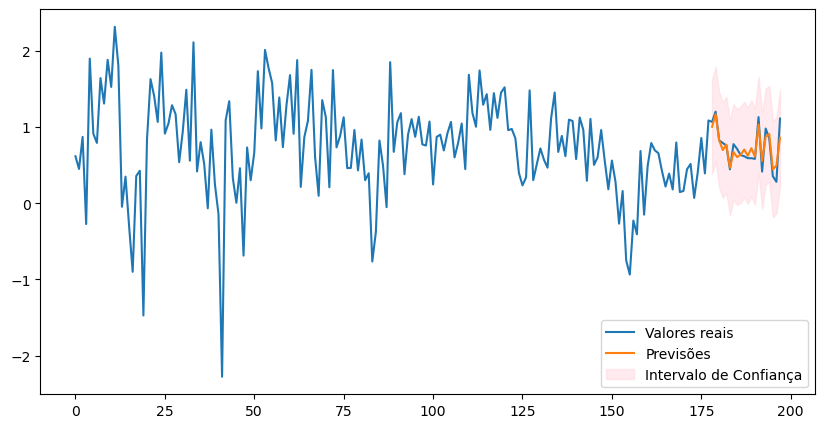

In [46]:
# Intervalo de confiança
conf_int = forecast_sarimax.conf_int()

# Visualizar previsões e intervalos
forecast_index = range(len(us_change["Consumption"])- forecast_steps, len(us_change["Consumption"]))
plt.figure(figsize=(10, 5))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_sarimax.predicted_mean, label="Previsões")
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label="Intervalo de Confiança")
plt.legend()
plt.show()

#### Auto Sarimax

In [47]:
mae = mean_absolute_error(data, fitted_values_auto_sarimax)

mse = mean_squared_error(data, fitted_values_auto_sarimax)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((data - fitted_values_auto_sarimax) / data)) * 100
r2 = r2_score(data, fitted_values_auto_sarimax)

# AIC e BIC
aic = auto_model.aic()
bic = auto_model.bic()


print(f"MAE: {mae}", f"MSE: {mse}", f"RMSE: {rmse}", 
      f"MAPE: {mape}%", f"R²: {r2}", f"AIC: {aic}", f"BIC: {bic}",
      sep="\n")

MAE: 0.23629631425782985
MSE: 0.10129931495342662
RMSE: 0.31827553307382367
MAPE: 69.60265856950464%
R²: 0.7712029112853415
AIC: 114.55784129440039
BIC: 143.14318888756486


In [48]:
mae_outsample = mean_absolute_error(real_values, forecast_auto_sarimax)
mse_outsample = mean_squared_error(real_values, forecast_auto_sarimax)

# Exibir as métricas para as previsões fora da amostra
print(f"Out-of-sample MAE: {mae_outsample}", f"MSE: {mse_outsample}", sep="\n")

Out-of-sample MAE: 0.08763370053570081
MSE: 0.012942298172784117


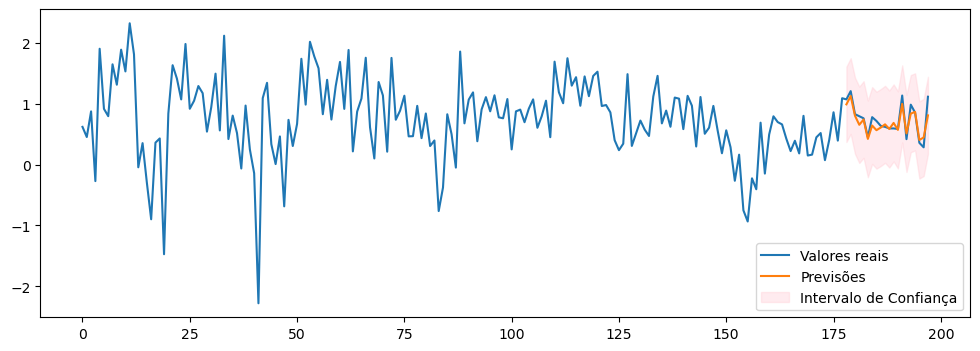

In [51]:
forecast_index = range(len(us_change["Consumption"]) - forecast_steps, len(us_change["Consumption"]) )

plt.figure(figsize=(12, 4))
plt.plot(us_change["Consumption"], label="Valores reais")
plt.plot(forecast_index, forecast_auto_sarimax, label="Previsões")
# Plot true values (in-sample)

plt.fill_between(forecast_index, 
                 conf_interval[:, 0], 
                 conf_interval[:, 1], 
                 color='pink', 
                 alpha=0.3, 
                 label="Intervalo de Confiança")
plt.legend()
plt.show()